# Solucion a las ecuaciones geodesicas de la metrica de schwarzschild

In [ ]:
!pip install numpy -q
!pip install sympy -q
!pip install git+https://github.com/einsteinpy/einsteinpy.git -q
!pip install einsteinpy  -q
!pip install -q rebound
!pip install -q astropy
!pip install -q spiceypy
!pip install -q scipy
!pip install -q astroquery

^C
ERROR: Operation cancelled by user


In [1]:
import numpy as np
import sympy as sp
import rebound as rb
from einsteinpy.symbolic import *
from scipy.constants import G,c
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import odeint
from matplotlib.patches import Circle
import sympy as sp

En este capitulo se trata de resolver las ecuaciones geodesicas que salen para la metrica de schwarzschild que ya habia sido tratada en el capitulo anterior.

Primero para resolver un problema astrofisico es necesario definir las unidades canonicas:

# Unidades del problema:

Mis unidades van a ser tales que:

$$
G = 1\;U_L^3/(U_M U_T^2),  c = 1\;U_L/U_T
$$

Si escojo $U_M$ puedo despejar $U_L$ así:

$$
U_L = G U_M/c^2
$$

Y teniendo $U_L$ puedo encontrar $U_T$:

$$
U_T = U_L/c
$$

Estas unidades se dan para el tratamiento interno de los datos, cuando una cantidad externa entra a ser parte de los calculos primero debe ser transformada, lo mismo para la cantidad que quiera ser mostrada al publico.
Estas unidades, son verdaderamente utiles a la hora de tratar con expresiones con constantes naturales porque las vuelve 1.

In [2]:
import rebound as rb

#Unidades primarias
U_m = rb.units.masses_SI['msolar']
U_l = G*U_m/c**2
U_t = U_l/c
print(f"Las unidades canonicas son: UL = {U_l:.3e} m, UM = {U_m:.3e} kg, UT = {U_t:.3e} s ")

#Unidades derivadas
U_v = U_l/U_t
U_a = U_l/U_t**2
U_f = U_a*U_m
print(f"Las unidades derivadas son: UV = {U_v:.3e} m/s, UA = {U_a:.3e} m/s^2, UF = {U_f:.3e} kg*m/s^2 ")

Las unidades canonicas son: UL = 1.477e+03 m, UM = 1.988e+30 kg, UT = 4.926e-06 s 
Las unidades derivadas son: UV = 2.998e+08 m/s, UA = 6.086e+13 m/s^2, UF = 1.210e+44 kg*m/s^2 


In [3]:
#Calculo de los simbolos de christoffel
s = sp.symbols('s')
S= sp.symbols('t, r, theta, phi')
t, r, q, f = S
t_, r_, q_, f_ = 0, 1, 2, 3
gcomp = sp.diag(1-s/r, -1/(1-s/r), -r**2,-r**2*sp.sin(q)**2).tolist()

g = MetricTensor(gcomp,S)

gij = g.tensor()
G=ChristoffelSymbols.from_metric(g)
Gijk=G.tensor()

# Ecuaciones diferenciales a resolver:

$\begin{aligned}
& \frac{\mathrm{d}^2 t}{\mathrm{~d} \lambda^2}+\frac{2 G M}{c^2 r^2\left(1-\frac{2 G M}{c^2 r}\right)} \frac{\mathrm{d} r}{\mathrm{~d} \lambda} \frac{\mathrm{d} t}{\mathrm{~d} \lambda}=0 \\
& \frac{\mathrm{d}^2 r}{\mathrm{~d} \lambda^2}+\frac{G M}{r^2}\left(1-\frac{2 G M}{c^2 r}\right)\left(\frac{\mathrm{d} t}{\mathrm{~d} \lambda}\right)^2-\frac{G M}{c^2 r^2\left(1-\frac{2 G M}{c^2 r}\right)}\left(\frac{\mathrm{d} r}{\mathrm{~d} \lambda}\right)^2 \\
& \quad-r\left(1-\frac{2 G M}{c^2 r}\right)\left[\left(\frac{\mathrm{d} \theta}{\mathrm{d} \lambda}\right)^2+\sin ^2 \theta\left(\frac{\mathrm{d} \phi}{\mathrm{d} \lambda}\right)^2\right]=0 \\
& \frac{\mathrm{d}^2 \theta}{\mathrm{d} \lambda^2}+\frac{2}{r} \frac{\mathrm{d} r}{\mathrm{~d} \lambda} \frac{\mathrm{d} \theta}{\mathrm{d} \lambda}-\sin \theta \cos \theta\left(\frac{\mathrm{d} \phi}{\mathrm{d} \lambda}\right)^2=0 \\
& \frac{\mathrm{d}^2 \phi}{\mathrm{d} \lambda^2}+\frac{2}{r} \frac{\mathrm{d} r}{\mathrm{~d} \lambda} \frac{\mathrm{d} \phi}{\mathrm{d} \lambda}+2 \frac{\cos \theta}{\sin \theta} \frac{\mathrm{d} \theta}{\mathrm{d} \lambda} \frac{\mathrm{d} \phi}{\mathrm{d} \lambda}=0
\end{aligned}$

Para resolver estas ecuaciones, es necesario llevarlas a la forma canonica con las unidades ya definidas y  describir las condiciones fisicas del sistema, las cuales son:
- La masa del cuerpo central.
- Posicion espacio temporal y tri velocidad de la particula (vector de estado fisico).
- Velocidades a fin, estas son, las derivadas de las coordenadas respecto al parametro a fin, las cuales son calculadas teniendo las velocidades fisicas y las coordenadas. Estas son : $$\frac{dt}{d\lambda},\frac{dr}{d\lambda},\frac{d\theta}{d\lambda},\frac{d\phi}{d\lambda}$$

# Ecuaciones de movimiento en unidades canonicas

In [4]:
def geo_edm(Y, lamb, s):
    
    t,r,q,f = Y[:4]
    ut,ur,uq,uf = Y[4:]
    
    dtdl = ut
    drdl = ur
    dqdl = uq
    dfdl = uf
    
    dutdl = -s/(r**2*(1-s/r))*ur*ut
    durdl = -s/(2*r**2)*(1-s/r)*ut**2 + (s/(2*r**2*(1- s/r)))*ur**2 + r*(1-s/r)*(uq**2 + np.sin(q)**2*uf**2)
    duqdl = -2/r*ur*uq + np.sin(q)*np.cos(q)*uf**2
    dufdl = -2/r*ur*uf - 2*np.cos(q)/np.sin(q)*uq*uf
    
    return [dtdl, drdl, dqdl, dfdl, dutdl, durdl, duqdl, dufdl]

In [5]:
from scipy.constants import G,c

# Propiedades del cuerpo central:

In [6]:
# Dato astrofísico
M = 2e31 #kg

Todas mis cantidades tienen que estar en unidades canónicas:

In [7]:
M = M / U_m
print(f"La masa en unidades canónicas es: {M}")

La masa en unidades canónicas es: 10.057956884661118


El radio de Schwarzschild de este cuerpo es:

$$
s = \frac{2 G M}{c^2}
$$

si $m$ está en unidades canónicas entonces el radio de Schwarzschild es:

$$
s = 2M
$$

In [8]:
s = 2*M
print(f"El radio de Schwarzschild del cuerpo es: {s} UL = {s*U_l} m")

El radio de Schwarzschild del cuerpo es: 20.115913769322237 UL = 29704.641076474658 m


# Para resolver esta ecuacion es necesario el vector de estado:

Con el proposito de encontrar las velocidades a fin, quiere decir esto, las coordenadas espacio temporales derivadas respecto al parametro a fin; las cuales tienen el siguiente aspecto:

$$\frac{dt}{d\lambda},\frac{dr}{d\lambda},\frac{d\theta}{d\lambda},\frac{d\phi}{d\lambda}$$

Las coordenadas espacio temporales y las velocidades fisicas tienen el siguiente tratamiento:

Las velocidades son mejor expresarlas en términos de la velocidad circular, que es la velocidad que tiene una partícula a una distancia $r$ de un cuerpo de masa $M$.  Según la teoría de Newton la velocidad circular se obtiene igualando la aceleración centrípeta $v^2/r$ y la aceleración de la gravedad $GM/r^2$

$$
v^2/r=GM/r^2
$$
Me da que la velocidad es:

$$
v_c=\sqrt{\frac{GM}{r}}
$$

Si el cuerpo estuviera en esta orbita su periodo seria:

$$
T = \frac{2\pi r}{v_c}
$$

Pero este seria el tiempo medido por un observador externo. El tiempo que nosotros necesitamos es el tiempo propio que en el movimiento geodesico juega el papel de $\lambda$.  La relacion entre ambos esta en esta ecuacion:

$$
\frac{dt}{d\lambda}=\frac{1}{1-s/r}
$$


Esta expresion para el tiempo sale de el  principio lagrangiano, este dice que las coordenadas que no aparecen en  el lagrangiano, que es lo mismo que no aparezca en los coeficientes de la metrica explicitamente, determinan,conservaciones y variables ciclicas.
Veamos el desarrollo de esto:

$$\frac{d}{d \lambda}\left(\frac{\partial L}{\partial \dot{x}^u}\right)-\frac{\partial L}{\partial x^u}=0$$

Donde el lagrangiano es:

$$L=\sqrt{g_{u v}(\tilde{x}) u^\mu u^v}$$

Como no depende de las coordenadas ya mencionadas entonces:

$$\frac{d}{d \lambda}\left(\frac{\partial L}{\partial \dot{X} u}\right)=0$$

$$\frac{\partial L}{\partial \dot{x}^k}=K, \frac{\partial L}{\partial u^k}=K$$

Desarrollando:

$$\frac{\partial}{\partial u^k} \sqrt{g_{u v} u^u u^v}=\frac{g_{u v}\left(\frac{\partial u^u}{\partial u^k} \cdot u^v+\frac{\partial u^v}{\partial u^k} u^u\right)}{2 L}$$

$$=\frac{g_{u v}\left(\delta^u_k u^v+\delta^v_k u^u\right)}{2 L}=\frac{\left(g_{k v}u^v+g_{v k}u^u\right)}{2 L}$$

$$=\frac{1}{L}g_{v k}u^v=K$$

Definiendo vector de killing como : 

$$\xi^k=(0,0,...,1,...,0,0)$$

Donde k representa la posicion k-esima, esta posicion es 1 y el resto son cero.
Se puede escribir la ecuacion anterior entonces como:

$$g_{u v}\xi^u u^v= k'$$ en este caso k'=L*K

notemos que $$L=\sqrt{g_{u v}(\tilde{x}) u^\mu u^v}=c$$

Esto ocurre porque $u_v u^v=c^2 $ (Leer sobre definicion de cuadrivelocidad y multiplicacion de cuadrivectores)

En este caso, como la coordenada del tiempo no aparece en la metrica de schwarzschild se tiene:

$$g_{0 v}\xi^0 u^v= k'=c$$

Como la metrica es diagonal solo permite la componente 00 y  $u^v=\frac{dx^v}{d\lambda}$:

$$k=g_{0 0}\xi^0 \frac{dx^0}{d\lambda}= cg_{0 0}\xi^0 \frac{dt}{d\lambda}=c(1-s/r)\frac{dt}{d\lambda}$$

Ajustando el parametro a fin para que k=1 se obtiene la expresion de dilatacion del tiempo:

$$
\frac{dt}{d\lambda}=\frac{1}{1-s/r}
$$

Mostrando la cantidad conservada se reemplaza el radio de schwarzschild y se identifica la energia especifica como un invariante:

$$
\frac{E}{mc^2}=(1-\frac{2GM}{c^2r}) \frac{dt}{d\lambda}
$$

se cumple para un contexto de caida libre para una particula masiva moviendose a lo largo de una geodesica temporaloide en el espacio de schwarzschild, esta cantidad es identificable porque la simetria asociada a la invarianza bajo traslaciones determina la conservacion de la energia.

Se sabe que el vector velocidad en coordendas esfericas es :
$$\vec{v}=\dot{r}\hat{e_r}+r\dot{\theta}\hat{e_{\theta}}+rsin\theta\dot{\phi}\hat{e_{\phi}}$$

Donde: 

$$\dot{r}=\frac{dr}{dt}$$

$$\dot{\theta}=\frac{d\theta}{dt}$$

$$\dot{\phi}=\frac{d\phi}{dt}$$

$$v_r=\dot{r}$$

$$v_{\theta}=r\dot{\theta}$$

$$v_{\phi}=rsin\theta\dot{\phi}$$
Entonces segun las siguientes figuras 

<div class="container">
      <div class="image"> <img src="esfericas.svg" alt="This is my image." height="200px"/> </div> 
      <div class="image"> <img src=" mejor.jpeg" alt="This is my image." height="200px"/> </div> 

Se tiene entonces que, para un punto de coordenadas 
$$(r,\theta,\phi)$$ 
    y
$$(v_r,v_{\theta},v_{\phi})$$
se define esto como el vector de estado dinamico.    

Luego de tener este vector, se calculan las velocidades afines que vienen dadas por:
    
$$\frac{dr}{d\lambda}=\frac{dr}{dt}\frac{dt}{d\lambda}$$
    
$$\frac{d\theta}{d\lambda}=\frac{d\theta}{dt}\frac{dt}{d\lambda}$$
    
$$\frac{d\phi}{d\lambda}=\frac{d\phi}{dt}\frac{dt}{d\lambda}$$

reemplazando los valores calculados anteriormente:

$$\frac{dr}{d\lambda}=v_r\frac{1}{1-s/r}$$
    
$$\frac{d\theta}{d\lambda}=\frac{v_{\theta}}{r}\frac{1}{1-s/r}$$
    
$$\frac{d\phi}{d\lambda}=\frac{v_{\phi}}{rsin(\theta)}\frac{1}{1-s/r}$$

con esto, se tiene el vector de estado a fin necesario para la resolucion de las ecuaciones diferenciales.

# Coordenadas espacio temporales y vector de estado

In [72]:
deg=np.pi/180
rad=1/deg

In [73]:
# Posiciones
t = 0
r = 5*s
teta = 90*deg # Arranco con un cuerpo en el ecuador del sistema
fi = 0*deg # Esta en el meridiano 0 del cuerpo

# Velocidad circular
vc = np.sqrt(M/r) 
T = 2*np.pi*r/vc*(1-s/r)

print(f"La velocidad circular de este cuerpo a una distancia {r} UL es {vc} UV = {vc*U_v/1000} km/s")
print(f"El periodo clasico de la orbita seria {T} UT = {T*U_t/1e-6} us")

La velocidad circular de este cuerpo a una distancia 100.57956884661118 UL es 0.31622776601683794 UV = 94802.69926203671 km/s
El periodo clasico de la orbita seria 1598.7465671077991 UT = 7874.871319892375 us


# Ahora las velocidades pero en unidades fisicas.

In [74]:
#Condiciones iniciales en unidades dinámicas

# Velocidades físicas
v_r = 0.0 
v_teta = 0.3 # No se mueve ni hacia arriba ni hacia abajo
v_fi = vc # Velocidad circular

#Magnitud de la velocidad (o rapidez). Esta cantidad debe ser menor que 1
v = (v_r**2 + v_teta**2 + v_fi**2)**0.5

print(f"La rapidez del cuerpo es {v} UV = {v*U_v/1000} km/s")

La rapidez del cuerpo es 0.43588989435406733 UV = 130676.50284576617 km/s


In [75]:
#Velocidades afines
ut = 1/(1-s/r)
ur = 1/(1-s/r)*v_r
uq = 1/(1-s/r)*v_teta/r
uf = 1/(1-s/r)*v_fi/(r*np.sin(teta))

In [76]:
estado = [t, r, teta, fi, ut, ur, uq, uf]

In [77]:
lambs = np.linspace(0, T, 100)

In [78]:
Ys = odeint(geo_edm, estado, lambs, args=(s,))

In [79]:
Ys.shape

(100, 8)

In [80]:
ts = Ys[:,0]
rs = Ys[:,1]
qs = Ys[:,2]
fs = Ys[:,3]
dtdls = Ys[:,4]
drdls = Ys[:,5]
dqdls = Ys[:,6]
dfdls = Ys[:,7]

Constantes:

In [81]:
(1-s/rs)*dtdls

array([1.        , 1.        , 1.        , 1.        , 0.99999999,
       1.        , 1.        , 1.        , 1.00000001, 1.00000001,
       1.00000001, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000

In [82]:
rs**2*dfdls

array([39.75756545, 39.90156949, 40.33207481, 41.04442934, 42.03046394,
       43.27795189, 44.76999141, 46.48442494, 48.39347127, 50.46369542,
       52.65644889, 54.92883924, 57.23522112, 59.52910351, 61.76529441,
       63.90205317, 65.90298387, 67.7385002 , 69.38669619, 70.8335972 ,
       72.07283484, 73.10485165, 73.93582052, 74.5763868 , 75.04041642,
       75.34381889, 75.50353446, 75.53670175, 75.46003628, 75.28938419,
       75.03942394, 74.72350325, 74.35357487, 73.94020224, 73.49261594,
       73.018802  , 72.52560829, 72.01885874, 71.50346744, 70.9835578 ,
       70.46253883, 69.94322815, 69.42792689, 68.91849599, 68.41642127,
       67.92287153, 67.43874844, 66.96473023, 66.50130773, 66.04881751,
       65.60746755, 65.17736034, 64.7585117 , 64.35086728, 63.95431606,
       63.56870202, 63.19383377, 62.82949193, 62.47543675, 62.13141291,
       61.79715424, 61.47238814, 61.15683769, 60.85022531, 60.55227673,
       60.26271212, 59.98126272, 59.70766221, 59.44164775, 59.18

In [83]:
xs = rs*np.sin(qs)*np.cos(fs)
ys = rs*np.sin(qs)*np.sin(fs)
zs = rs*np.cos(qs)

In [84]:
def sphere(r):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    return x,y,z
x,y,z = sphere(s)

/tmp/ipykernel_5101/1436750360.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xs,ys,zs,'k-',color="orange")


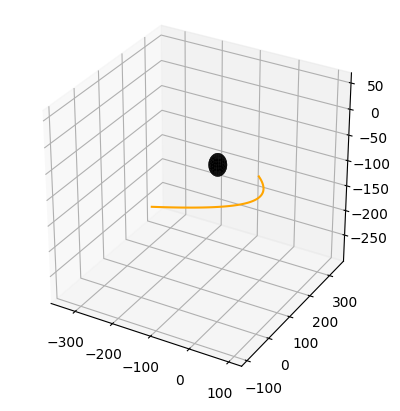

In [85]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot(xs,ys,zs,'k-',color="orange")
ax.plot([0], [0], [0], color='orange') 
ax.plot_surface(x, y, z, rstride=4, cstride=4, color='black')
ax.axis("equal")
ax.set_box_aspect([1,1,1])

In [37]:
def orbita_rg(r=10*s, f_c=1, NT=1,M=10):
    # Posiciones
    t = 0
    r=r
    teta = 90*deg # Arranco con un cuerpo en el ecuador del sistema
    fi = 0*deg # Esta en el meridiano 0 del cuerpo

    # Velocidad circular
    vc = np.sqrt(M/r) 
    T = 2*np.pi*r/vc*(1-s/r)
    print(f"La velocidad circular de este cuerpo a una distancia {r} UL es {vc} UV = {vc*U_v/1000} km/s")

    #Condiciones iniciales en unidades dinámicas

    # Velocidades físicas
    v_r = 0.01
    v_teta = 0.0 # No se mueve ni hacia arriba ni hacia abajo
    v_fi = f_c*vc # Velocidad circular

    #Magnitud de la velocidad (o rapidez). Esta cantidad debe ser menor que 1
    v = (v_r**2 + v_teta**2 + v_fi**2)**0.5
    print(f"La rapidez del cuerpo es {v} UV = {v*U_v/1000} km/s")

    #Velocidades afines
    ut = 1/(1-s/r)
    ur = 1/(1-s/r)*v_r
    uq = 1/(1-s/r)*v_teta/r
    uf = 1/(1-s/r)*v_fi/(r*np.sin(teta))

    #El vector de estado
    estado = [t, r, teta, fi, ut, ur, uq, uf]
    #Tiempo de integracion
    lambs = np.linspace(0, NT*T, 100)

    #Resolvemos
    Ys = odeint(geo_edm, estado, lambs, args=(s,))

    #Sacamos la solucion en coordenadas esfericas
    rs = Ys[:,1]
    qs = Ys[:,2]
    fs = Ys[:,3]

    #Convertimos a cartesianas
    xs = rs*np.sin(qs)*np.cos(fs)
    ys = rs*np.sin(qs)*np.sin(fs)
    zs = rs*np.cos(qs)

    #Graficamos
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(xs,ys,'r-')
    ax.set_title('Orbita de una particula masiva')
    plt.xlabel("U_l")
    plt.ylabel("U_l")
    c=Circle((0,0),s,color='k')
    ax.add_patch(c)
    ax.grid()
    ax.axis("equal");
    
    return Ys

La velocidad circular de este cuerpo a una distancia 201.15913769322236 UL es 0.22296162315332071 UV = 66842.21304480374 km/s
La rapidez del cuerpo es 0.24546156793475377 UV = 73587.52679569382 km/s


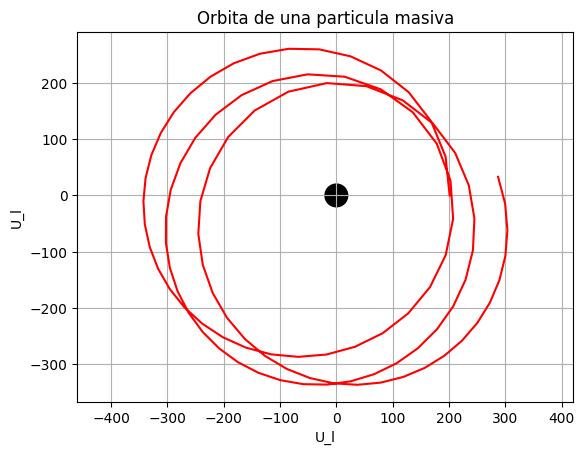

In [40]:
Ys = orbita_rg(r=10*s, f_c=1.1, NT=5)

In [41]:
ts = Ys[:,0]
rs = Ys[:,1]
qs = Ys[:,2]
fs = Ys[:,3]
dtdls = Ys[:,4]
drdls = Ys[:,5]
dqdls = Ys[:,6]
dfdls = Ys[:,7]

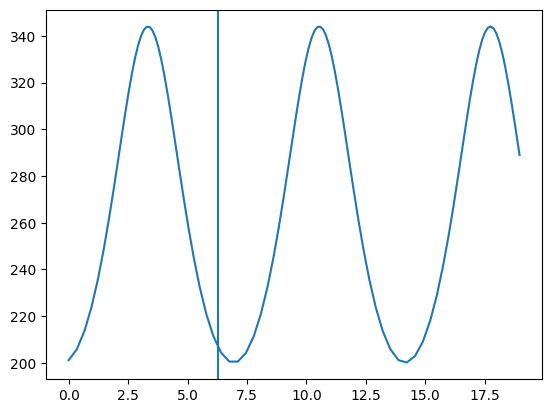

In [45]:
plt.plot(fs,rs)
plt.axvline(2*np.pi)

In [46]:
from scipy.signal import find_peaks

In [50]:
find_peaks(-rs)

(array([36, 72]), {})

In [51]:
rs[36]

200.54396844429914

In [55]:
delta=(fs[72]-fs[36])-2*np.pi
delta

0.8272545096051953

La velocidad circular de este cuerpo a una distancia 80.46365507728895 UL es 0.35253327998631345 UV = 105686.81853389912 km/s
La rapidez del cuerpo es 0.38791552344868757 UV = 116294.14827103868 km/s


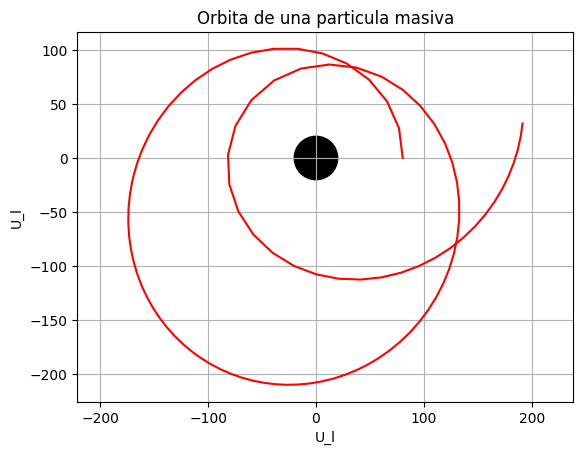

In [33]:
orbita_rg(r=4*s, f_c=1.1, NT=5)


# Experimentos

# Dependecia de la precesión del perihelo con la distancia.

La expresion para el calculo de la preseción viene dada por :

$$\delta=\frac{6\pi G M}{c^2a(1-e^2)}$$

In canonic units:

$$\delta=\frac{6\pi}{a(1-e^2)}$$

Deduccion en el lorenzo de la torre, sale de usar las 2 convervaciones de la metrica.

# La 3era ley de kepler no se cumple

La velocidad circular de este cuerpo a una distancia 60.347741307966714 UL es 0.40707036819679954 UV = 122036.62626068357 km/s
La rapidez del cuerpo es 0.4071931785576447 UV = 122073.4438806292 km/s


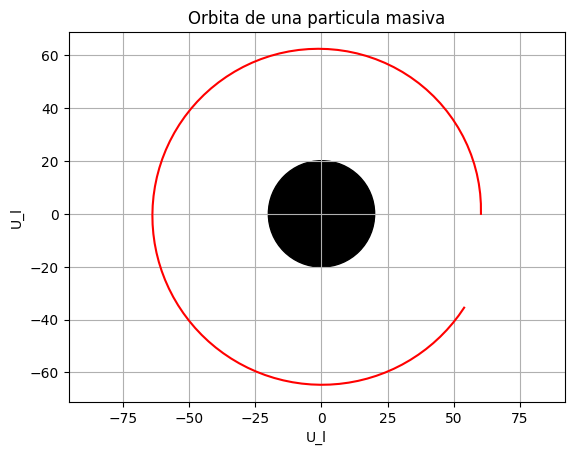

In [60]:
Ys=orbita_rg(r=3*s,NT=1)

La tercera ley de Kepler establece que el cuadrado del período orbital de un planeta alrededor del Sol es directamente proporcional al cubo de la distancia promedio del planeta al Sol. Es una ley empírica que se basa en la observación de los movimientos planetarios en el sistema solar.

Cuando se aplica la métrica de Schwarzschild a la órbita de un planeta alrededor del Sol, se encuentra que la órbita no es exactamente una elipse perfecta como lo predice la ley de Kepler. En lugar de eso, hay pequeñas desviaciones en la órbita que pueden ser explicadas por la curvatura del espacio-tiempo causada por la presencia del Sol.

Estas desviaciones son muy pequeñas y no se pueden observar directamente en el sistema solar. Sin embargo, pueden ser medidas con gran precisión utilizando técnicas como la interferometría láser. De hecho, las mediciones precisas de la órbita de Mercurio revelaron una pequeña desviación de la órbita que fue explicada por la teoría de la relatividad de Einstein.

# valores positivos o negativos de la velocidad circular


La velocidad circular de este cuerpo a una distancia 201.15913769322236 UL es 0.22296162315332071 UV = 66842.21304480374 km/s
La rapidez del cuerpo es 0.24546156793475377 UV = 73587.52679569382 km/s


array([[ 0.00000000e+00,  2.01159138e+02,  1.57079633e+00,
         0.00000000e+00,  1.11111111e+00,  1.11111111e-02,
         0.00000000e+00, -1.35469188e-03],
       [ 5.72505789e+01,  2.01805749e+02,  1.57079633e+00,
        -6.95979745e-02,  1.11071568e+00,  1.39730993e-02,
         5.73628220e-21, -1.34602458e-03],
       [ 1.14478562e+02,  2.02598171e+02,  1.57079633e+00,
        -1.38701371e-01,  1.11023490e+00,  1.67678422e-02,
         1.13425488e-20, -1.33551576e-03],
       [ 1.71679666e+02,  2.03532628e+02,  1.57079633e+00,
        -2.07218198e-01,  1.10967329e+00,  1.94833938e-02,
         1.67903900e-20, -1.32328068e-03],
       [ 2.28849852e+02,  2.04604753e+02,  1.57079633e+00,
        -2.75062770e-01,  1.10903594e+00,  2.21089398e-02,
         2.20547071e-20, -1.30944907e-03],
       [ 2.85985360e+02,  2.05809657e+02,  1.57079633e+00,
        -3.42156398e-01,  1.10832844e+00,  2.46349064e-02,
         2.71140255e-20, -1.29416175e-03],
       [ 3.43082727e+02,  2.071419

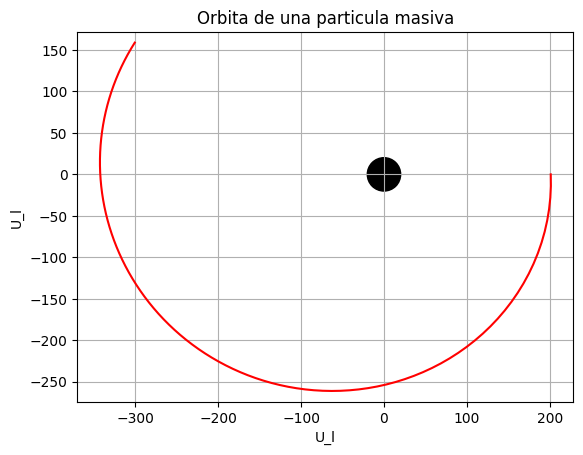

In [61]:
orbita_rg(r=10*s, f_c=-1.1, NT=1)


La velocidad circular de este cuerpo a una distancia 201.15913769322236 UL es 0.22296162315332071 UV = 66842.21304480374 km/s
La rapidez del cuerpo es 0.24546156793475377 UV = 73587.52679569382 km/s


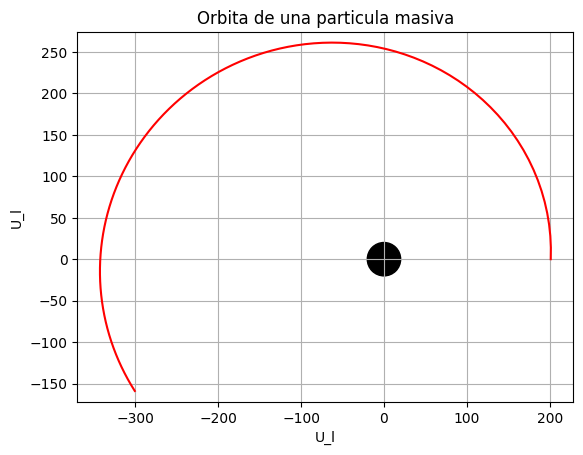

In [27]:
orbita_rg(r=10*s, f_c=1.1, NT=1)


# Tryaectoria para un foton.

In [67]:
def orbita_luz(r=10*s, v_r=0,v_teta=0,v_fi=1, NT=1,M=10):
  
    # Posiciones
    t = 0
    
    teta = 90*deg # Arranco con un cuerpo en el ecuador del sistema
    fi = 0*deg # Esta en el meridiano 0 del cuerpo
    m=M
    # Velocidad circular
    vc = 1 
    T = 2*np.pi*r/vc*(1-s/r)

    #Condiciones iniciales en unidades dinámicas

    # Velocidades físicas
  #  v_r = 0.00
   # v_teta = 0.0 # No se mueve ni hacia arriba ni hacia abajo
   # v_fi = 1 # Velocidad circular

    #Magnitud de la velocidad (o rapidez). Esta cantidad debe ser menor que 1
    v = (v_r**2 + v_teta**2 + v_fi**2)**0.5

    #Velocidades afines
    ut = 1/(1-s/r)
    ur = 1/(1-s/r)*v_r
    uq = 1/(1-s/r)*v_teta/r
    uf = 1/(1-s/r)*v_fi/(r*np.sin(teta))

    #El vector de estado
    estado = [t, r, teta, fi, ut, ur, uq, uf]
    #Tiempo de integracion
    lambs = np.linspace(0, T, 100)

    #Resolvemos
    Ys = odeint(geo_edm, estado, lambs, args=(s,))

    #Sacamos la solucion en coordenadas esfericas
    rs = Ys[:,1]
    qs = Ys[:,2]
    fs = Ys[:,3]

    #Convertimos a cartesianas
    xs = rs*np.sin(qs)*np.cos(fs)
    ys = rs*np.sin(qs)*np.sin(fs)
    zs = rs*np.cos(qs)

    #Graficamos
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(xs,ys,'y-')
    c=Circle((0,0),s,color='k')
    ax.add_patch(c)
    ax.grid()
    ax.axis("equal");
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')

    ax.plot(xs,ys,zs,'k-',color="orange")
    ax.plot([0], [0], [0], color='orange') 
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color='black')
    ax.axis("equal")
    ax.set_box_aspect([1,1,1])

/tmp/ipykernel_5101/46419649.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xs,ys,zs,'k-',color="orange")


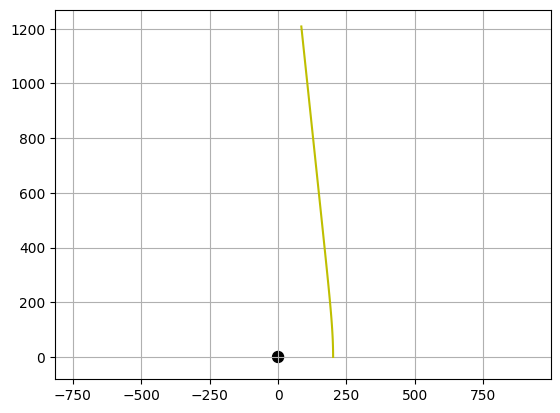

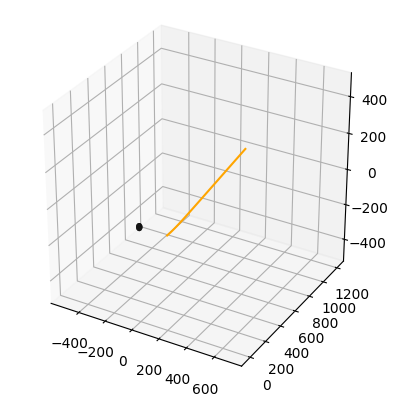

In [68]:
orbita_luz()

/tmp/ipykernel_5101/46419649.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xs,ys,zs,'k-',color="orange")


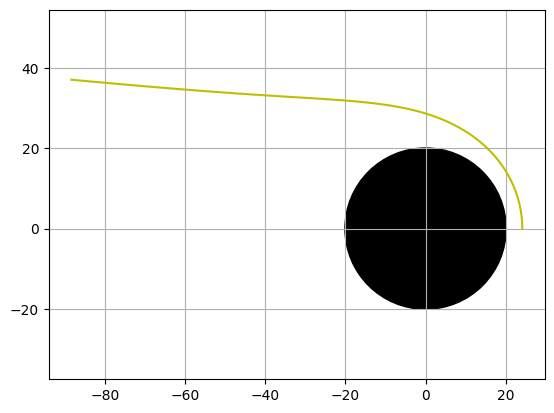

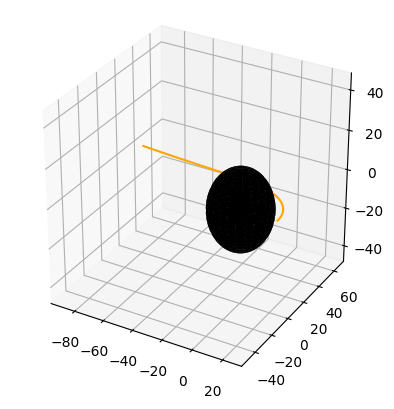

In [71]:
orbita_luz(r=1.2*s)

/tmp/ipykernel_2780/385219603.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xs,ys,zs,'k-',color="orange")


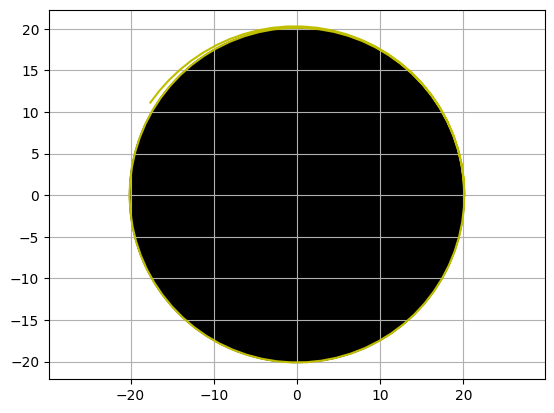

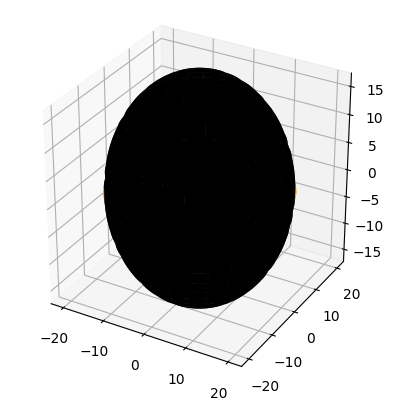

In [50]:
orbita_luz(r=1.000001*s)

/tmp/ipykernel_2780/385219603.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xs,ys,zs,'k-',color="orange")


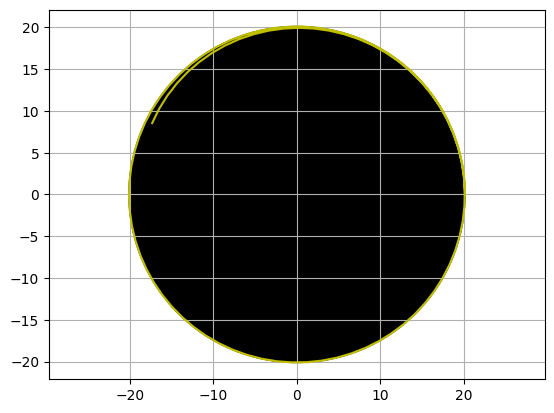

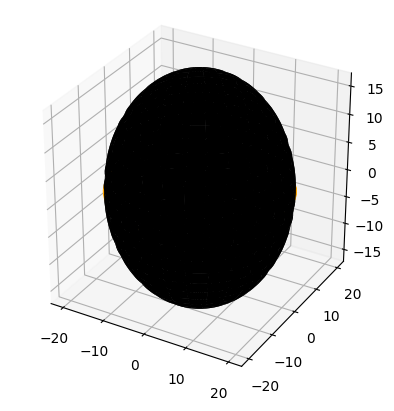

In [51]:
orbita_luz(r=0.999999*s)

Estas son las trayectorias para un foton que orbita un agujero negro, en el ultimo ejemplo podemos ver como la geodesica que sigue el foto va hacia la singularidad.